notebook generates rebinned spectra and physical quantities, given specified integration time 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy import optimize
from scipy.optimize import curve_fit

from create_arrays_combo import create_arr

In [2]:
# import arrays
tube = readsav('/Users/WilliamHenryAshfieldIV/dat/ebtel_l85_h325_subI.sav',verbose=False,python_dict=False)
frac = readsav('/Users/WilliamHenryAshfieldIV/dat/ebtel_l85_h325_subI_si_iv_nei.sav',verbose=False,python_dict=False)
log10T,log10G = np.loadtxt('/Users/WilliamHenryAshfieldIV/dat/goft_1403.dat.txt',comments='%',unpack=True)

In [3]:
t_n = tube.tarr.shape[0] - 1 # len of tube in time (in steps of 0.1s)
line = 1402.77
ll = np.arange(line-10,line+10,0.01)

/Users/WilliamHenryAshfieldIV/synth_spec/create_arrays_combo.py:58: RuntimeWarning: invalid value encountered in true_divide
  temp_fac = f_nei/f_eqi
/Users/WilliamHenryAshfieldIV/synth_spec/create_arrays_combo.py:119: RuntimeWarning: invalid value encountered in true_divide
  factor = nei/eqi
/Users/WilliamHenryAshfieldIV/synth_spec/create_arrays_combo.py:183: RuntimeWarning: invalid value encountered in sqrt
  meas_error = np.sqrt(tot_emissNEI) # error measured


(1402, 1404)

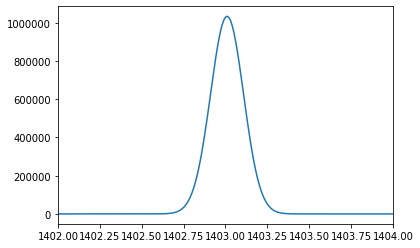

In [4]:
k = 135
test_arr = create_arr(tube,frac,log10T,log10G,time=k)
plt.plot(test_arr['wav'],test_arr['spec'])
plt.xlim(1402,1404)

In [5]:
ll = test_arr['wav']
t_n = 500

In [6]:
SPEC = np.zeros((t_n,len(test_arr['spec'])))
ERROR = np.zeros((t_n,len(test_arr['error'])))

for i in range(0,t_n):

    arrs = create_arr(tube,frac,log10T,log10G,time=i)

    SPEC[i,:] = arrs['spec'] 
    ERROR[i,:] = arrs['error']

/Users/WilliamHenryAshfieldIV/synth_spec/create_arrays_combo.py:119: RuntimeWarning: divide by zero encountered in true_divide
  factor = nei/eqi
/Users/WilliamHenryAshfieldIV/synth_spec/create_arrays_combo.py:165: RuntimeWarning: overflow encountered in double_scalars
  emissNEI[i,:] = photo_fac*EM[i]*factor[i]*10**g[i]/np.sqrt(2*np.pi)/sig[i]*np.exp(-(ll-line-line*v[i]/c)**2/(2*sig[i]**2))
/Users/WilliamHenryAshfieldIV/synth_spec/create_arrays_combo.py:165: RuntimeWarning: invalid value encountered in double_scalars
  emissNEI[i,:] = photo_fac*EM[i]*factor[i]*10**g[i]/np.sqrt(2*np.pi)/sig[i]*np.exp(-(ll-line-line*v[i]/c)**2/(2*sig[i]**2))


Text(0.5, 0, 'wavelength [$\\AA$]')

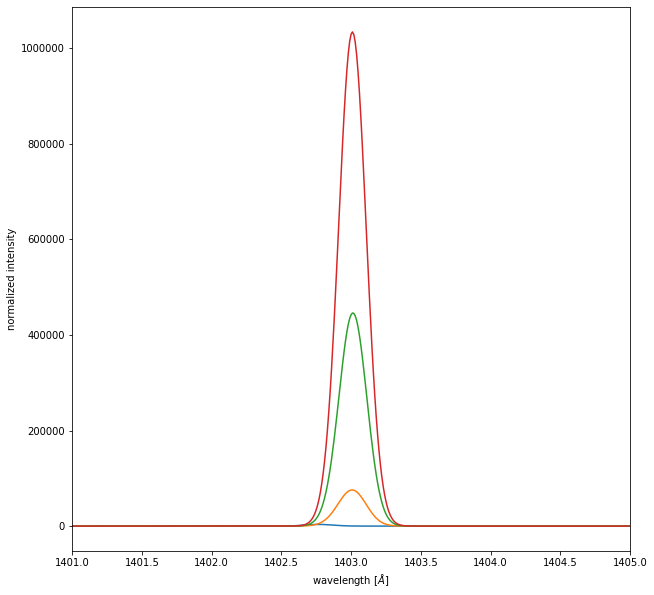

In [7]:
fig, ax = plt.subplots(figsize=[10,10])
plt.plot(ll,SPEC[100,:])
plt.plot(ll,SPEC[125,:])
plt.plot(ll,SPEC[130,:])
plt.plot(ll,SPEC[135,:])
plt.xlim(1401,1405)
plt.ylabel('normalized intensity')
ax.set_xlabel('wavelength [$\AA$]')

In [8]:
SPEC.shape

(500, 2000)

# Rebin our synthetic spectrum:

In [9]:
dt = 0.2
inegration = 5 # seconds (iris)
reshape = int(inegration/dt)
reshape

25

In [10]:
SPECII = SPEC.reshape(-1,reshape,2000)
SPECII.shape

ERRORII = ERROR.reshape(-1,reshape,2000)
ERRORII.shape

(20, 25, 2000)

In [11]:
spec = np.mean(SPECII,axis=1)
error = np.mean(ERRORII,axis=1)

In [12]:
nt = error.shape[0] # number of time elements after rebin.
print(nt)

20


Text(0.5, 0, 'wavelength [$\\AA$]')

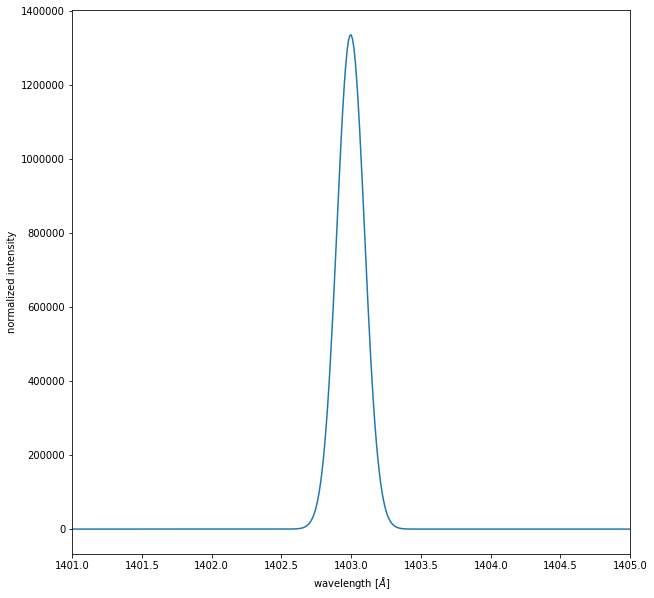

In [13]:
fig, ax = plt.subplots(figsize=[10,10])
plt.plot(ll,spec[5,:])
plt.xlim(1401,1405)
plt.ylabel('normalized intensity')
ax.set_xlabel('wavelength [$\AA$]')

Save new specturm array to txt file:

In [14]:
# np.savetxt('../dat/rebins/f4_t10_h20_tri.txt', spec, fmt='%d')
# np.savetxt('../dat/rebins/f4_t10_h20_tri_err.txt', error, fmt='%d')

# Animate our rebinned spectrum:

In [15]:
from matplotlib import animation, rc
from IPython.display import HTML

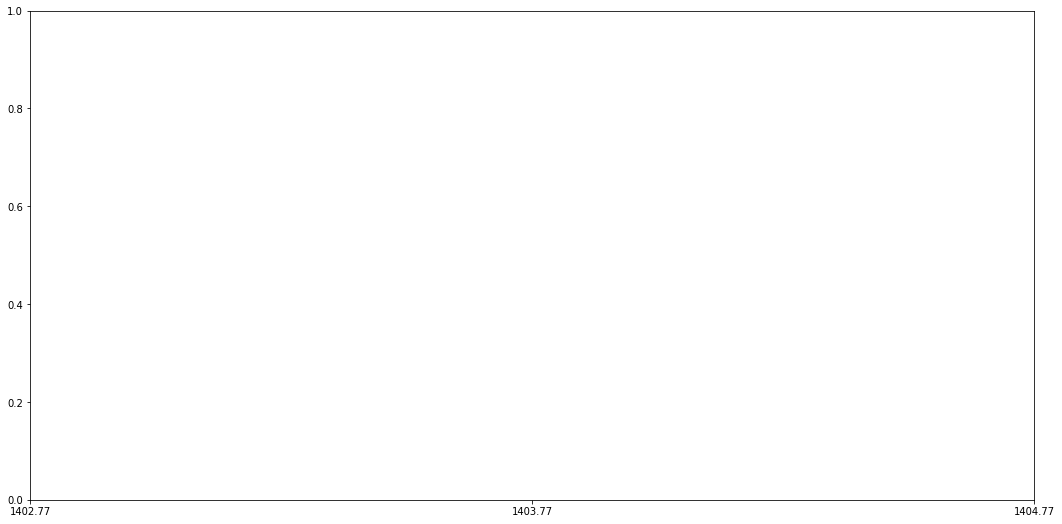

In [16]:
fig, ax = plt.subplots(figsize=(18,9))
ax.set_xlim(1402.77,1404)
ax.set_xticks(np.arange(1402.77, 1405, 1))

In [17]:
# data placeholders
wav,specs = np.zeros(0),np.zeros(0)#,np.zeros(0),np.zeros(0),np.zeros(0),np.zeros(0),np.zeros(0)

# plot placeholder/object
plot_spec, = ax.plot(wav,specs)

In [18]:
def update(i):

    global wav
    global specs
    
    wav = ll
    specs = spec[i,:]
    
    plot_spec.set_data(wav,specs)
   
    plot_spec.axes.set_ylim(0,np.max(specs)+0.05*np.max(specs))
    time = np.around(i*5, decimals=1)
    plot_spec.axes.set_ylim(0,np.max(specs)+0.05*np.max(specs))
    plot_spec.axes.set_title('time = '+str(time)+'s')
    plot_spec.axes.ticklabel_format(style='sci',axis='y',useMathText=False,scilimits=(0,2))
    
    return plot_spec

In [19]:
simulation = animation.FuncAnimation(fig, update, blit=False, frames= nt, interval=250, repeat=False)

In [20]:
HTML(simulation.to_html5_video())

In [21]:
#simulation.save(filename='sml.mp4',fps=2,dpi=300)

In [22]:
spec.shape

(20, 2000)

# Time series of synthetic spectrum:

In [23]:
20*5

100

In [24]:
time = np.arange(0,spec.shape[0]*5,5)
nt = len(time)-1

In [25]:
from fit2gauss import fit2gauss
v_r = np.zeros(nt)
v_b = np.zeros(nt)
w_r = np.zeros(nt)
w_b = np.zeros(nt)

amp = np.zeros(nt)

for i in range(0,nt):
    
    t_i = time[i]
    
    dat = spec[i,:]
    err = error[i,:]
        
    res = fit2gauss(ll,dat,err,chi_thr=100.)
    a2g = res["a2g"] # extract fit parameters
    a1g = res["a1g"]

    #calculate Doppler velocities and wavelengths
    line = 1402.77
    c = 300.
    freq = c/line*1e3

    amp[i] = a1g[0]

    if a2g[1] < a2g[4]:
        v_b[i] = (a2g[1]-line)/line*3e5 # in km/s
        v_r[i] = (a2g[4]-line)/line*3e5
        #w_b[i] = a2g[2]*freq
        #w_r[i] = a2g[5]*freq

    else:
        v_r[i] = (a2g[1]-line)/line*3e5 # in km/s
        v_b[i] = (a2g[4]-line)/line*3e5
        #w_r[i] = a2g[2]*freq
        #w_b[i] = a2g[5]*freq

(0, 60)

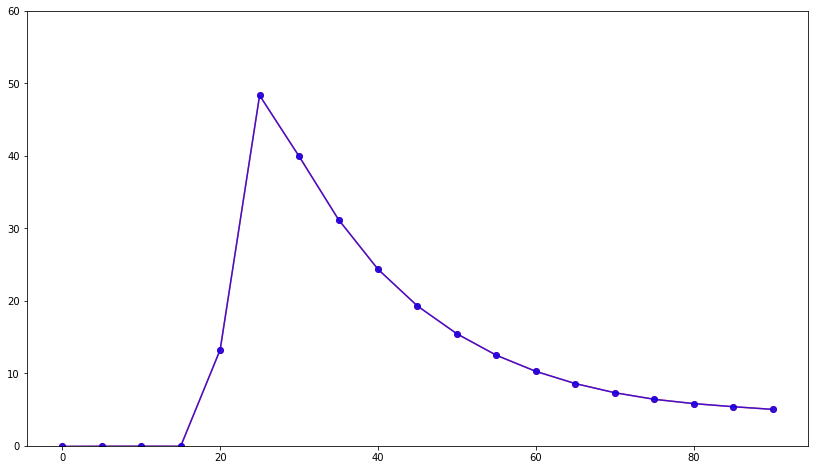

In [26]:
plt.figure(figsize=(14,8))
plt.plot(time[0:-1],v_r,'r',alpha=0.75,marker='o')
plt.plot(time[0:-1],v_b,'b',alpha=0.75,marker='o')
plt.ylim(0,60)

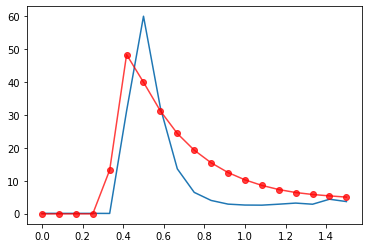

In [27]:
plt.plot(time[0:-1]/60,amp/np.max(amp)*60)
plt.plot(time[0:-1]/60,v_r,'r',alpha=0.75,marker='o')

In [28]:
#jj = np.where((ll > 1402) & (ll < 1405))[0]
spec_fit,error_fit = spec[4,:],error[4,:]
#ll = ll[jj]
res = fit2gauss(ll,spec_fit,error_fit,chi_thr=50.,verbose=True)

est params =  [232.44411679624244, 1403.3438416990905, 0.1, 2697.066967503478, 1402.8055303168117, 0.1]
spec_peaks =  [ 2.46710945e-165  8.39559012e-164  1.57564011e-160  2.41279030e-160
 -3.09339661e-158  4.73381532e-155  1.77107015e-152  9.39520116e-151
  2.90251613e-146  4.53848589e-146  3.87890550e-143  5.88983331e-140
  1.41179532e-136  1.92927416e-135  5.76984063e-132 -2.19859374e-132
  3.33839665e-128  2.42576935e-126  6.24086233e-123  1.28163654e-120
  2.69412605e-119  2.94480367e-117  2.44968244e-116  4.95049557e-113
  1.93768795e-109  2.14938256e-108  1.16300265e-105  2.63051329e-103
  4.02665198e-103  1.14302091e-099  2.37650374e-098  1.06199218e-097
  7.21958405e-096  6.65351020e-094  7.94485454e-092  1.10832829e-086
  1.41724326e-085  5.47447912e-083  2.81266533e-081  5.70128395e-080
  1.76426618e-077  1.46772407e-076  9.92587784e-076  3.82445495e-073
  3.40315573e-071  2.87976103e-070  3.20557296e-068  3.81426530e-067
  1.74398251e-066  2.80117278e-066  2.90431378e-063  5

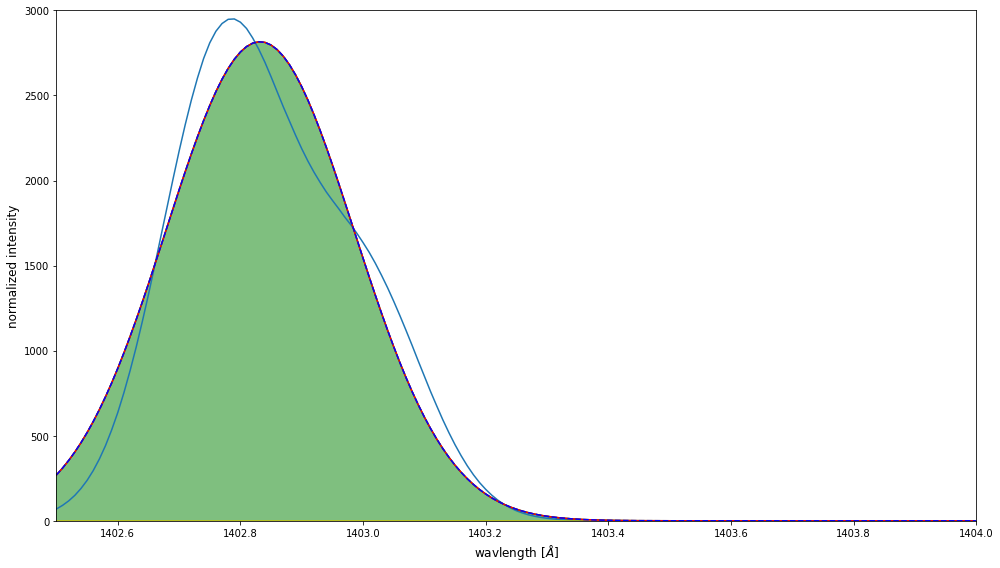

In [29]:
from matplotlib import gridspec
# extract arrays
y2a = res["y2a"]
y2b = res["y2b"]
y1g = res["y1g"]

#plot 
fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])

# spectra
ax1.plot(ll, spec_fit)

# peak 1
ax1.plot(ll, y2a, "g")
ax1.fill_between(ll, y2a.min(), y2a, facecolor="green", alpha=0.5)
  
# peak 2
ax1.plot(ll, y2b, "y")
ax1.fill_between(ll, y2b.min(), y2b, facecolor="yellow", alpha=0.5) 

#both
ax1.plot(ll,y2a+y2b, "r")

# single fit
ax1.plot(ll,y1g,'b--')
    
plt.xlim(1402.5,1404)
plt.ylim(0,3000)
ax1.set_xlabel("wavlength [$\AA$]",  fontsize=12)
ax1.set_ylabel("normalized intensity",  fontsize=12)
fig.tight_layout()

# Fit:

In [30]:
def u0_fit(t, *a):
    return a[0]/(1+t/a[1])

In [31]:
imax = np.argmax(v_r) 

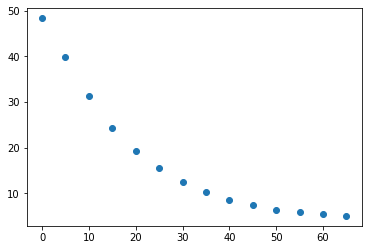

In [32]:
tt = time[imax:-1] 
tt = tt-tt[0]
vr = v_r[imax:]
plt.plot(tt,vr,'o')

In [33]:
a0= [55,15]
popt, pcov = curve_fit(u0_fit, tt, vr,p0=a0)

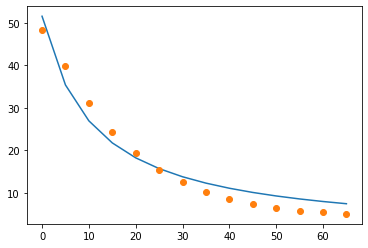

In [34]:
plt.plot(tt,u0_fit(tt,*popt))
plt.plot(tt,vr,'o')

In [35]:
popt[0]

51.54115116378056

In [36]:
H = 0.6*popt[0]*popt[1]

In [37]:
H

338.2883435008902